In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import joblib
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
df = pd.read_csv('realtor-data.zip.csv')

In [4]:
df.head()

,status,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date,price
0,for_sale,3.0,2.0,0.12,Adjuntas,Puerto Rico,601.0,920.0,NaN,105000.0
1,for_sale,4.0,2.0,0.08,Adjuntas,Puerto Rico,601.0,1527.0,NaN,80000.0
2,for_sale,2.0,1.0,0.15,Juana Diaz,Puerto Rico,795.0,748.0,NaN,67000.0
3,for_sale,4.0,2.0,0.10,Ponce,Puerto Rico,731.0,1800.0,NaN,145000.0
4,for_sale,6.0,2.0,0.05,Mayaguez,Puerto Rico,680.0,NaN,NaN,65000.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2701666 entries, 0 to 2701665
Data columns (total 10 columns):
 #   Column          Dtype  
---  ------          -----  
 0   status          object 
 1   bed             float64
 2   bath            float64
 3   acre_lot        float64
 4   city            object 
 5   state           object 
 6   zip_code        float64
 7   house_size      float64
 8   prev_sold_date  object 
 9   price           float64
dtypes: float64(6), object(4)
memory usage: 206.1+ MB


In [6]:
df.isnull().sum()

status                  0
bed                399631
bath               423182
acre_lot           609678
city                  304
state                   0
zip_code              525
house_size         714844
prev_sold_date    1207206
price                 271
dtype: int64

C:\Users\brand\AppData\Local\Temp\ipykernel_38544\537848829.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(df.isnull().sum().sort_values(ascending=False), palette='bright')


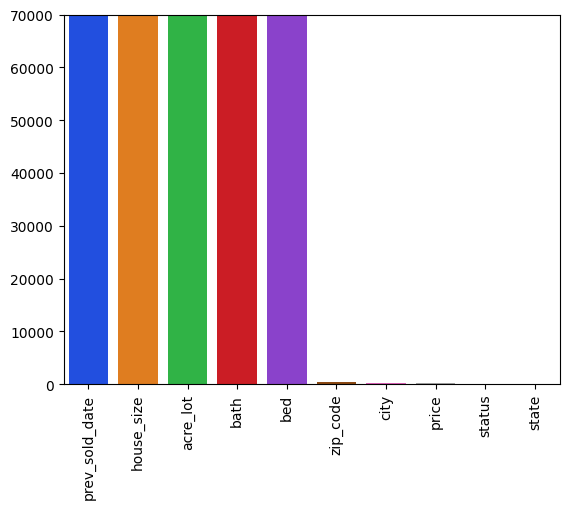

In [7]:
# visualizing the missing values by column
sns.barplot(df.isnull().sum().sort_values(ascending=False), palette='bright')
plt.ylim(0, 70000)
plt.xticks(rotation = 90);

In [8]:
# drop the prev_sold_date column because it is missing half the values
df = df.drop('prev_sold_date', axis = 1)

In [9]:
# drop null values for city, zip_code and price
df.dropna(subset=['city', 'zip_code', 'price'], inplace=True)

In [10]:
# drop all rows where bed and bath values are missing
df = df.drop(df[(df['bed'].isnull()) & (df['bath'].isnull())].index, axis = 0)

In [11]:
# drop all rows where acre_lot and house_size values are missing
df = df.drop(df[(df['acre_lot'].isnull()) & (df['house_size'].isnull())].index, axis = 0)

In [12]:
# drop all rows where bath and house_size values are missing
df = df.drop(df[(df['bed'].isnull()) & (df['house_size'].isnull())].index, axis = 0)

In [13]:
# drop all rows where bed and house_size values are missing
df = df.drop(df[(df['bath'].isnull()) & (df['house_size'].isnull())].index, axis = 0)

In [14]:
# use linear regression to predict missing values for house_size
# the features we will use are bed, bath, acre_lot and price
df.corr()['house_size'].sort_values(ascending=False)[1:]

bath        0.327969
bed         0.298033
price       0.133048
acre_lot   -0.001558
zip_code   -0.009030
Name: house_size, dtype: float64

In [15]:
# gather training data from df and drop nulls
house_size_df = df[['bed', 'bath', 'acre_lot', 'price', 'house_size']].dropna()

2043839    1560780.0
2071886    1560780.0
2084401    1560780.0
2058645    1560780.0
10328      1450112.0
479983      400149.0
475143      400149.0
1247259     352836.0
1227984     352836.0
1243647     352836.0
Name: house_size, dtype: float64

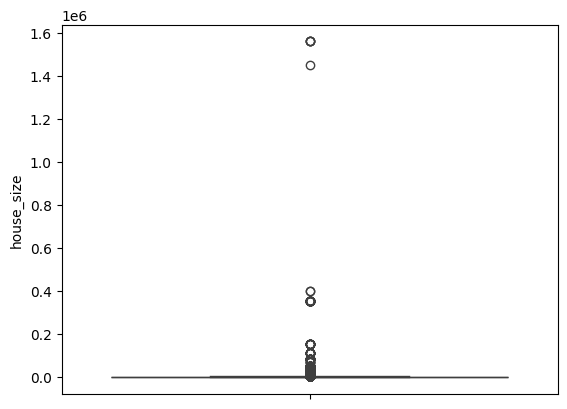

In [16]:
# check for outliers that may skew results
sns.boxplot(house_size_df['house_size'].sort_values(ascending=False))
house_size_df['house_size'].sort_values(ascending=False)[:10]

<Axes: ylabel='house_size'>

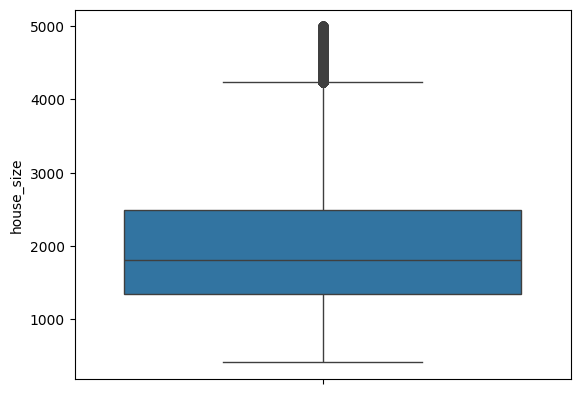

In [17]:
# drop rows with house_size values over 5000
house_size_df = house_size_df[(house_size_df['house_size'] < 5000) & (house_size_df['house_size'] > 400)]

sns.boxplot(house_size_df['house_size'].sort_values(ascending=False))

In [18]:
len(house_size_df)

1393252

In [19]:
# separate features and target
# split the data
X = house_size_df.drop('house_size', axis = 1)
y = house_size_df['house_size']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [20]:
# scale the data
house_scaler = StandardScaler()
X_train_scaled = house_scaler.fit_transform(X_train)
X_test_scaled = house_scaler.transform(X_test)

In [21]:
# create and train the model
model = LinearRegression()
model.fit(X_train_scaled,y_train)

LinearRegression()

In [22]:
# get predictions and evaluate
y_hat = model.predict(X_test_scaled)
print(f'mae: {mean_absolute_error(y_test, y_hat)}')
print(f'mse: {mean_squared_error(y_test, y_hat)}')
print(f'mse: {np.sqrt(mean_squared_error(y_test, y_hat))}')

mae: 420.6089593586851
mse: 331851.91278683546
mse: 576.0658927473796


In [23]:
# mean absolute error is 20% of the average house size, not the best accuracy but also not too bad.
420/house_size_df['house_size'].mean()

0.2083724495146771

In [24]:
# use a sequential model to make predictions instead
tf_model = Sequential()
tf_model.add(Dense(28, activation = 'relu'))
tf_model.add(Dense(14, activation = 'relu'))
tf_model.add(Dense(7, activation = 'relu'))
tf_model.add(Dense(1))

tf_model.compile(loss='mean_absolute_error', optimizer = 'adam', metrics = ['mae'])

In [25]:
stop = EarlyStopping(patience = 1, monitor = 'val_loss')
tf_model.fit(X_train_scaled, y_train, epochs = 100, validation_data=(X_test_scaled, y_test), callbacks = [stop])

Epoch 1/100


39186/39186 [==============================] - 78s 2ms/step - loss: 430.4566 - mae: 430.4566 - val_loss: 411.7456 - val_mae: 411.7456
Epoch 2/100
39186/39186 [==============================] - 78s 2ms/step - loss: 412.9640 - mae: 412.9640 - val_loss: 411.7128 - val_mae: 411.7128
Epoch 3/100
39186/39186 [==============================] - 79s 2ms/step - loss: 412.9297 - mae: 412.9297 - val_loss: 411.3683 - val_mae: 411.3683
Epoch 4/100
39186/39186 [==============================] - 75s 2ms/step - loss: 412.9065 - mae: 412.9065 - val_loss: 411.0939 - val_mae: 411.0939
Epoch 5/100
39186/39186 [==============================] - 78s 2ms/step - loss: 412.9308 - mae: 412.9308 - val_loss: 410.9589 - val_mae: 410.9589
Epoch 6/100
39186/39186 [==============================] - 78s 2ms/step - loss: 412.9190 - mae: 412.9190 - val_loss: 411.4243 - val_mae: 411.4243


In [26]:
# sequential model performed a little bit better
# gather the rows and features where house_size is null and store in df
X_house_size = df[df['house_size'].isnull()][['bed', 'bath', 'acre_lot', 'price']]

In [27]:
# scale the data
X_house_size_scaled = house_scaler.fit_transform(X_house_size)

In [28]:
# use the sequential model to predict
house_size_preds = tf_model.predict(X_house_size_scaled)

7693/7693 [==============================] - 11s 1ms/step


In [29]:
# grab indices of rows where house_size is missing data
house_size_null_index = df[df['house_size'].isnull()].index

# reshape predictions to be 1 dimension and round the numbers off
# put into a series and set the index to match the index of our df of missing house_size values
house_size_preds_series = pd.Series(np.round(house_size_preds.reshape(-1))).set_axis(house_size_null_index)

# fill the values in place and update the house_size column
df['house_size'] = df['house_size'].fillna(house_size_preds_series)

In [30]:
df.isnull().sum()

status             0
bed            25053
bath           58093
acre_lot      474614
city               0
state              0
zip_code           0
house_size         0
price              0
dtype: int64

In [31]:
# Now do the same for the acre_lot column using the house_size, price and state 'house_size', 'state', 'price', 'acre_lot'
acre_lot_df = df[['house_size', 'state', 'price', 'acre_lot']].dropna()

1211362    100000.0
1291326    100000.0
18822      100000.0
1148665    100000.0
1208460    100000.0
1296282    100000.0
372810     100000.0
1159947    100000.0
1298107    100000.0
376972     100000.0
Name: acre_lot, dtype: float64

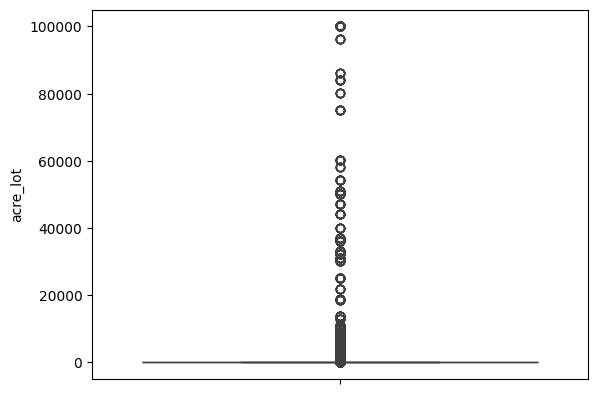

In [32]:
# check for outliers that may skew results
sns.boxplot(acre_lot_df['acre_lot'].sort_values(ascending=False))
house_size_df['acre_lot'].sort_values(ascending=False)[:10]

<Axes: ylabel='acre_lot'>

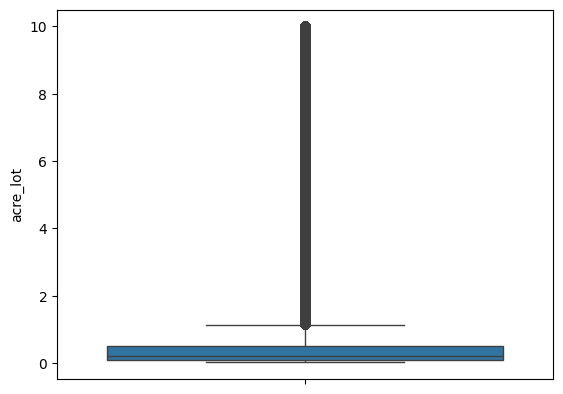

In [33]:
# drop rows with acre_lot values over 10 acres and less than 0.01
acre_lot_df = acre_lot_df[(acre_lot_df['acre_lot'] <= 10) & (acre_lot_df['acre_lot'] > 0.01)]
sns.boxplot(acre_lot_df['acre_lot'].sort_values(ascending=False))

In [34]:
# get dummies for the state column
acre_lot_df = pd.get_dummies(acre_lot_df)

In [154]:
# separate features and target
# split the data
X = acre_lot_df.drop('acre_lot', axis = 1)
y = acre_lot_df['acre_lot']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [155]:
# scale the data
acre_scaler = StandardScaler()
X_train_scaled = acre_scaler.fit_transform(X_train)
X_test_scaled = acre_scaler.transform(X_test)

In [156]:
# create and train the model
model = LinearRegression()
model.fit(X_train_scaled,y_train)

RandomForestRegressor()

In [157]:
# get predictions and evaluate
y_hat = model.predict(X_test_scaled)
print(f'mae: {mean_absolute_error(y_test, y_hat)}')
print(f'mse: {mean_squared_error(y_test, y_hat)}')
print(f'mse: {np.sqrt(mean_squared_error(y_test, y_hat))}')

mae: 0.053086544816300464
mse: 0.08989961368193271
mse: 0.29983264278916116


In [39]:
# mae is even higher than the average acre_lot size so this model is very inaccurate with the available features. 
acre_lot_df['acre_lot'].mean()

0.6243275573812778

In [40]:
# few of the properties have over 50 acres so we will drop anything over 50 acres
# then fill null values with the mean instead
df = df[df['acre_lot'] <= 50]

In [41]:
df['acre_lot'].fillna(df['acre_lot'].mean(), inplace=True)

In [42]:
df.isnull().sum()

status            0
bed            7033
bath          17835
acre_lot          0
city              0
state             0
zip_code          0
house_size        0
price             0
dtype: int64

In [43]:
# drop remaining missing values
df = df.dropna(subset=['bed', 'bath'])

In [44]:
df.isnull().sum()

status        0
bed           0
bath          0
acre_lot      0
city          0
state         0
zip_code      0
house_size    0
price         0
dtype: int64

In [45]:
# clean up more outliers in the dataset
df = df[(df['house_size'] < 10000) & (df['house_size'] > 400)]
df = df[(df['acre_lot'] < 10) & (df['acre_lot'] > 0.01)]
df = df[df['bed'] <= 10]
df = df[df['bath'] <= 10]

<Axes: ylabel='price'>

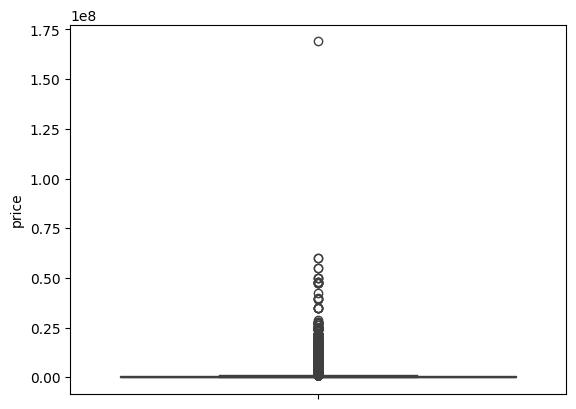

In [46]:
sns.boxplot(df['price'])

In [47]:
df['price'].sort_values(ascending=False)[:10]

734849     169000000.0
1129947     60000000.0
1137706     60000000.0
1129900     55000000.0
1137548     55000000.0
743290      50000000.0
565325      49900000.0
741930      49900000.0
1137922     48000000.0
1139270     48000000.0
Name: price, dtype: float64

In [48]:
len(df[df['price'] > 10000000])

1261

In [49]:
# remove price values over 10 million and under 25000
df = df[(df['price'] < 10000000) & (df['price'] > 25000)]

In [50]:
# reset the index
df.reset_index(inplace=True, drop = True)

In [51]:
df.head()

,status,bed,bath,acre_lot,city,state,zip_code,house_size,price
0,for_sale,3.0,2.0,0.12,Adjuntas,Puerto Rico,601.0,920.0,105000.0
1,for_sale,4.0,2.0,0.08,Adjuntas,Puerto Rico,601.0,1527.0,80000.0
2,for_sale,2.0,1.0,0.15,Juana Diaz,Puerto Rico,795.0,748.0,67000.0
3,for_sale,4.0,2.0,0.10,Ponce,Puerto Rico,731.0,1800.0,145000.0
4,for_sale,6.0,2.0,0.05,Mayaguez,Puerto Rico,680.0,2069.0,65000.0


In [52]:
df.to_csv('cleaned_realtor_data.csv', index = False)

Visualizations

In [167]:
df.corr()['price'].sort_values(ascending=False)[1:]

bath          0.599577
house_size    0.584671
bed           0.346822
acre_lot      0.100796
zip_code     -0.105563
Name: price, dtype: float64

<Axes: >

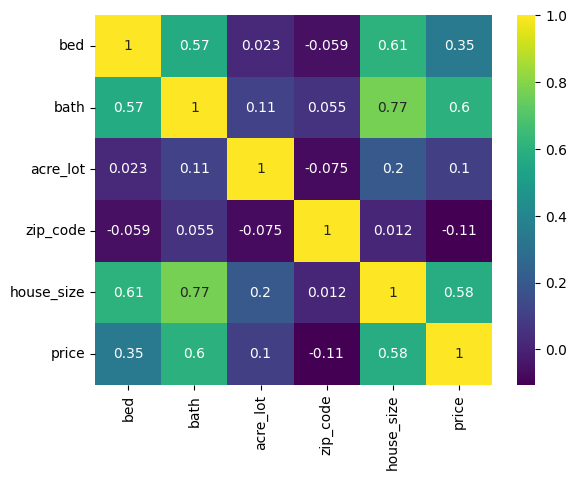

In [168]:
# create heatmap of correlations
sns.heatmap(df.corr(), annot = True, cmap='viridis')

<Axes: xlabel='house_size', ylabel='price'>

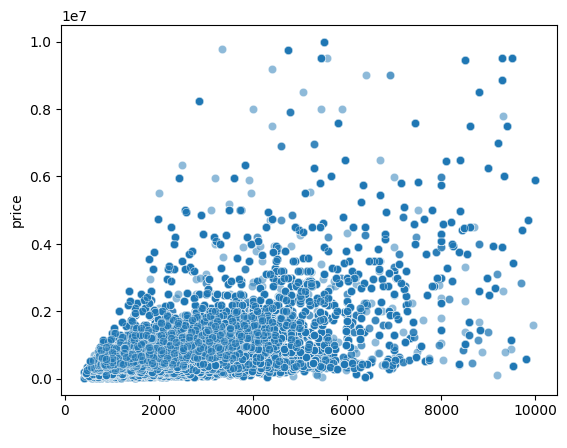

In [194]:
# scatterplot showing correlation between house_size and price
sns.scatterplot(data=df.head(100000), x='house_size', y='price', alpha = .5)

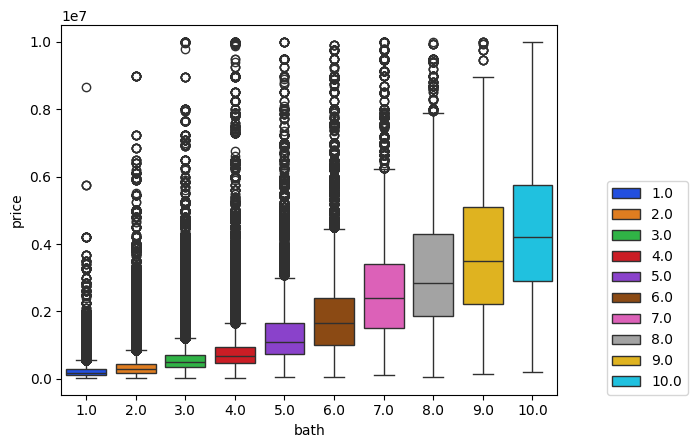

In [177]:
# clear correlation between bath and price using a boxplot
sns.boxplot(data=df, x='bath', y = 'price', palette = 'bright', hue = 'bath')
plt.legend(loc = (1.1,0))

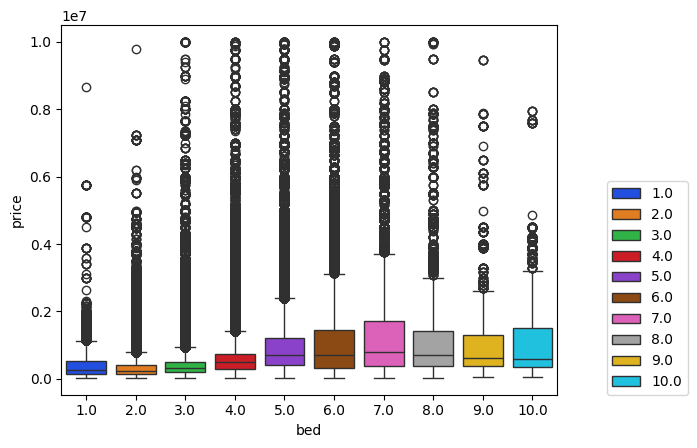

In [195]:
sns.boxplot(data=df, x='bed', y = 'price', palette = 'bright', hue = 'bed')
plt.legend(loc = (1.1,0))

(0.0, 50000.0)

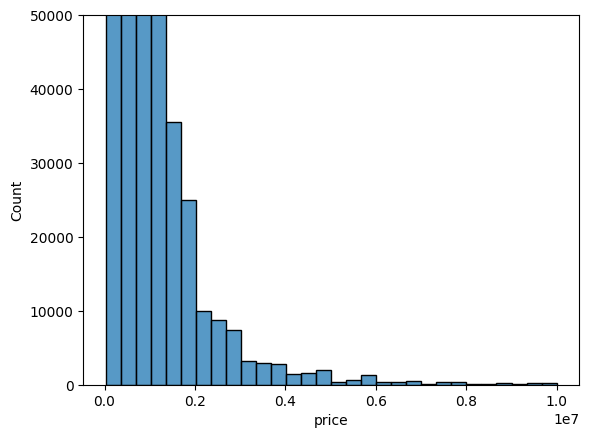

In [199]:
sns.histplot(data=df, x = 'price', bins = 30)
plt.ylim(0,50000)

Prepare the data for making price predictions with Scikit-Learn and Tensorflow


In [53]:
# drop the for_sale column because there is only 1 unique value
df['status'].unique()
preprocessed_df = df.drop('status', axis = 1 )

In [54]:
preprocessed_df['city'].nunique()

4863

In [55]:
# Cities has nearly 5000 unique values so we will convert the cities into their respective value counts/frequencies
city_counts = preprocessed_df['city'].value_counts()
preprocessed_df['city'] = preprocessed_df['city'].apply(lambda x: city_counts.loc[x])

In [56]:
preprocessed_df['zip_code'].nunique()

6109

In [57]:
# we will do the same with zip_code to reduce the size of the values
zip_code_counts = preprocessed_df['zip_code'].value_counts()
preprocessed_df['zip_code'] = preprocessed_df['zip_code'].apply(lambda x: zip_code_counts.loc[x])

In [58]:
# use the OneHotEncoder to get dummies for the state column
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output= False).set_output(transform= 'pandas')

In [59]:
# fit and transform the state column
ohetransform = ohe.fit_transform(preprocessed_df[['state']])

In [60]:
# add the new columns to the dataframe and drop the state column
preprocessed_df = pd.concat([preprocessed_df, ohetransform], axis = 1).drop(['state'], axis = 1)

In [61]:
preprocessed_df.head()

,bed,bath,acre_lot,city,zip_code,house_size,price,state_Colorado,state_Connecticut,state_Delaware,...,state_New York,state_Ohio,state_Pennsylvania,state_Puerto Rico,state_Rhode Island,state_Vermont,state_Virgin Islands,state_Virginia,state_West Virginia,state_Wyoming
0,3.0,2.0,0.12,33,33,920.0,105000.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,2.0,0.08,33,33,1527.0,80000.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,1.0,0.15,128,117,748.0,67000.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,2.0,0.10,479,190,1800.0,145000.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6.0,2.0,0.05,378,278,2069.0,65000.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [163]:
# split the data into features and the target value
X = preprocessed_df.drop('price', axis = 1)
y = preprocessed_df['price']

In [164]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.20, random_state=42)

In [165]:
# scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [65]:
joblib.dump(scaler, 'housing_scaler.pkl')

['housing_scaler.pkl']

Begin Training the Models

In [66]:
# create linear regression model
# fit to training data
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

LinearRegression()

In [67]:
# make predictions
lr_preds = linear_model.predict(X_test_scaled)

In [68]:
# use metrics to analyze results
print(f'mae: {mean_absolute_error(y_test, lr_preds)}')
print(f'mse: {mean_squared_error(y_test, lr_preds)}')
print(f'rmse: {np.sqrt(mean_squared_error(y_test, lr_preds))}')

mae: 267733.0220612751
mse: 235236243600.81378
rmse: 485011.5912025338


In [69]:
# the linear regression model does not produce desireable results
# we will now try RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators = 130)

In [70]:
rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor(n_estimators=130)

In [71]:
rf_preds = rf_model.predict(X_test_scaled)
print(f'mae: {mean_absolute_error(y_test, rf_preds)}')
print(f'mse: {mean_squared_error(y_test, rf_preds)}')
print(f'rmse: {np.sqrt(mean_squared_error(y_test, rf_preds))}')

mae: 4692.527150805412
mse: 3591848491.1654763
rmse: 59932.032262934954


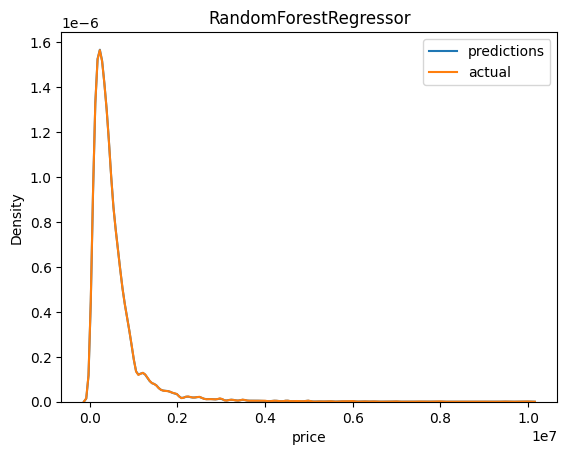

In [166]:
# RandomForestRegressor is nearly perfect at predicting housing prices
sns.kdeplot(data=rf_preds, label = 'predictions')
sns.kdeplot(data=y_test, label = 'actual')
plt.title('RandomForestRegressor')
plt.legend()

In [73]:
joblib.dump(rf_model, "housing_model.pkl")

['housing_model.pkl']

Our RandomForestRegressor Has Nearly Perfect Accuracy

In [74]:
city_series = df['city'].value_counts()

In [75]:
zip_series = df['zip_code'].value_counts()

Make Data Preparations For This Model to Work With a Flask App

In [76]:
# Save series to csv for preprocessing (converting data to their value counts) with new data
city_series.to_csv('city_series.csv')
zip_series.to_csv('zip_series.csv')

In [77]:
# get dataframe where each row has a unique state
# this df will be used to create a small dataframe to allow for one hot encoding when new data is added 
unique_states_df = df.drop_duplicates('state')
unique_states_df = unique_states_df.drop(['price', 'status'], axis = 1)
unique_states_df.head()

,bed,bath,acre_lot,city,state,zip_code,house_size
0,3.0,2.0,0.12,Adjuntas,Puerto Rico,601.0,920.0
6501,5.0,2.0,0.21,Saint Thomas,Virgin Islands,802.0,1140.0
13899,2.0,1.0,0.34,Agawam,Massachusetts,1001.0,676.0
15944,3.0,1.0,3.93,Willington,Connecticut,6279.0,1572.0
17019,3.0,3.0,0.07,Burlington,New Jersey,8016.0,1500.0


In [78]:
unique_states_df.to_csv('unique_states_df.csv', index = False)

In [101]:
# load in necessary files to run custom function below
zip_series = pd.read_csv('zip_series.csv')
city_series = pd.read_csv('city_series.csv')
loaded_scaler = joblib.load('housing_scaler.pkl')
loaded_model = joblib.load('housing_model.pkl')

In [86]:
# create a function to automatically preprocess new data
def preprocessing(unique_states_df, user_row, city_series, zip_series):
    
    # convert state and city to title case
    user_row['city'] = user_row['city'].str.title()
    user_row['state'] = user_row['state'].str.title()

    # read in city and zip csv files
    city_series = city_series.copy(deep=True)
    zip_series = zip_series.copy(deep=True)

    # convert to a series
    city_series.set_index('Unnamed: 0', inplace=True)
    city_series = city_series['city']

    try:
        # convert to city count
        user_row['city'] = city_series.loc[user_row['city'].iloc[0]]

    except:
        # if city not in training data, replace with 1
        city = user_row['city'].iloc[0]
        print(f'Model has never seen "{city}" before. Estimate may be inaccurate.')
        user_row['city'] = 1

    # convert to a series
    zip_series.set_index('Unnamed: 0', inplace=True)
    zip_series = zip_series['zip_code']

    try:
        # convert to zip count
        user_row['zip_code'] = zip_series.loc[user_row['zip_code'].iloc[0]]
    
    except:
        # if zip not in training data, replace with 1
        zip = user_row['zip_code'].iloc[0]
        print(f'Model has never seen zipcode "{zip}" before. Estimate may be inaccurate.')
        user_row['zip_code'] = 1

    unique_states_df['city'] = unique_states_df['city'].apply(lambda x: int(x == 0))
    
    # add row to unique df
    new_df = pd.concat([unique_states_df, user_row])

    # create encoder
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output= False).set_output(transform= 'pandas')
    ohetransform = ohe.fit_transform(new_df[['state']])
    new_df = pd.concat([new_df, ohetransform], axis=1).drop(['state'], axis=1)
    
    new_df = loaded_scaler.transform(new_df)

    return [new_df[-1]]


In [132]:
# run a test on data it hasn't seen before
target_value = df.loc[[X_test.index[0]]]['price'].iloc[0]
print(f'price target: ${target_value}')
test_row = df.loc[[X_test.index[0]]]
test_row = test_row.drop(['status', 'price'], axis = 1)
test_row

price target: $869000.0


,bed,bath,acre_lot,city,state,zip_code,house_size
88681,4.0,3.0,0.11,Milton,Massachusetts,2186.0,2438.0


In [133]:
test = preprocessing(unique_states_df, test_row, city_series, zip_series)

In [134]:
loaded_model.predict(test)[0]

869000.0

The RandomForesRegressor Was 100% Accurate With New Data That Was Preprocessed Using Our Function

Making Price Predictions with Tensorflow

In [96]:
tf_price_model = Sequential()

tf_price_model.add(Dense(256, activation = 'relu', input_shape = (25,)))
tf_price_model.add(Dense(256, activation = 'relu'))
tf_price_model.add(Dense(128, activation = 'relu'))
tf_price_model.add(Dense(64, activation = 'relu'))
tf_price_model.add(Dense(1))

tf_price_model.compile(loss='mean_absolute_error', optimizer = 'adam', metrics = ['mae'])
tf_price_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               6656      
                                                                 
 dense_5 (Dense)             (None, 256)               65792     
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 113665 (444.00 KB)
Trainable params: 113665 (444.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [97]:
stop = EarlyStopping(patience = 3, monitor = 'val_loss')
trained_tf_model = tf_price_model.fit(X_train_scaled, y_train, epochs = 300, validation_data=(X_test_scaled, y_test), callbacks=[stop])

Epoch 1/300
40314/40314 [==============================] - 149s 4ms/step - loss: 209973.6719 - mae: 209973.6719 - val_loss: 199457.8125 - val_mae: 199457.8125
Epoch 2/300
40314/40314 [==============================] - 159s 4ms/step - loss: 192554.1094 - mae: 192554.1094 - val_loss: 186103.1875 - val_mae: 186103.1875
Epoch 3/300
40314/40314 [==============================] - 161s 4ms/step - loss: 185044.0781 - mae: 185044.0781 - val_loss: 181720.6875 - val_mae: 181720.6875
Epoch 4/300
40314/40314 [==============================] - 164s 4ms/step - loss: 178428.7500 - mae: 178428.7500 - val_loss: 173959.6719 - val_mae: 173959.6719
Epoch 5/300
40314/40314 [==============================] - 158s 4ms/step - loss: 172902.8281 - mae: 172902.8281 - val_loss: 173131.1562 - val_mae: 173131.1562
Epoch 6/300
40314/40314 [==============================] - 156s 4ms/step - loss: 168758.8281 - mae: 168758.8281 - val_loss: 166038.8125 - val_mae: 166038.8125
Epoch 7/300
40314/40314 [=====================

In [141]:
history = pd.DataFrame(tf_price_model.history.history)

<Axes: >

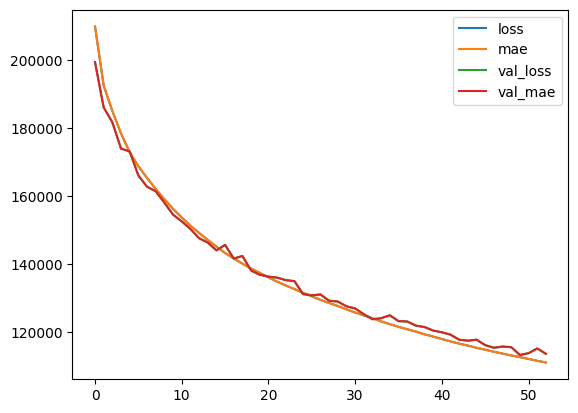

In [145]:
history.plot()

In [146]:
tf_model_preds = tf_price_model.predict(X_test_scaled)

10079/10079 [==============================] - 20s 2ms/step


In [147]:
# print metrics
print(f'mae: {mean_absolute_error(y_test, tf_model_preds)}')
print(f'mse: {mean_squared_error(y_test, tf_model_preds)}')
print(f'rmse: {np.sqrt(mean_squared_error(y_test, tf_model_preds))}')

mae: 113482.32520266753
mse: 73568421246.92393
rmse: 271234.99266673526


The Sequential Model is Not Nearly as Accurate as the RandomForestRegressor and Took Several Hours to Run

The Recommended Model For This Dataset is a RandomForestRegressor With n_estimators = 130